## GPS location data from mobile phones to study impacts of Bogota cable car opening

### Some background: 
- Flat part of bogota and some hills in the south that are now connected to the city center
- Providers (private company) that collect mobile phone data at a large scale (buy data for all of Colombia from and focus on region within the city)
- Now have two months worth of data for testing (have data from month after the opening of the cable car 2019, also a month from 2022)
- Goal: Do analysis to see if the month of data is good enough to be worth buying 2018 data (more expensive)
- How to know if it is good enough (2 key factors): How many observations appear in Bogota and what is their granularity and usefulness for tracking individual movements (e.g. can we see locations/movements between different neighborhoods?)

### Tasks: 
1) CALCULATE TOTAL NUMBER OF OBSERVATIONS IN BOGOTA
    - each observation is a ping, timestamped, individual identifiers for each device
2) REGULARITY OF OBSERVATIONS PER DEVICE OVER TIME
    - How long do I observe this device over the month? How often do I see each person per day?


### Notes from 2023-03-08: 
- Drop users seen for less than 5 days and with less than 60 pings. Also for the home determination, maybe change the "bed time" to 10pm to 530am or 6am (try 11pm-5am and 10pm-6am).
- Want to be able to determine the home locations of the people. 

#### Next steps:
- Plots of user loss as the cutoffs for pings and days are varied.
- Number of pings during hours when home locations could be computed (per user). How many people? (see above for cutoffs)
- Map of home locations, especially see the regions in the south if we have some users from there. Generate a heatmap. Want to see some granularity.

In [1]:
from datetime import datetime as dt
import pandas as pd
import unidecode
from matplotlib import pyplot as plt
import os
import glob
import numpy as np
import pyarrow.parquet as pq
import geopandas as gpd
import skmob
import contextily as cx
import mobilkit
import pytz
from matplotlib import cm
import statsmodels.api as sm


import seaborn as sns
from skmob.measures.individual import home_location
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import statsmodels.formula.api as smf
import time
import warnings
warnings.filterwarnings('ignore')
from shapely.geometry import Polygon

import folium

from dotenv import load_dotenv
load_dotenv()

# Access environment variables
data_dir = os.getenv('WORKING_DIR')

### Data

Elena gave me these potential column identifiers for the data: `['device_id', 'id_type', 'latitude', 'longitude', 'horizontal_accuracy',
       'timestamp', 'ip_address', 'device_os', 'os_version', 'user_agent',
       'country', 'source_id', 'publisher_id', 'app_id', 'location_context]`
Looking at the data it looks like the columns are actually:
`['device_id', 'id_type', 'latitude', 'longitude', 'horizontal_accuracy',
       'timestamp', '?', 'device_os', 'os_version', 'user_agent',
       'country', 'source_id', 'publisher_id', 'app_id', 'location_context]`

### Load metadata

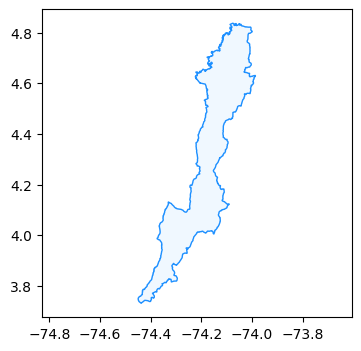

In [2]:
meta_folder = f'{data_dir}metadata/'
bogota_geo = f'{meta_folder}poligonos-localidades.shp'


# read in the shapefile with the geolocation data for Bogota
zats=gpd.read_file(bogota_geo)


# get the first boundary component as a Polygon object to map Bogota
boundary_bgta = Polygon(list(zats.geometry.unary_union.boundary.geoms)[0].coords) 
x, y = boundary_bgta.exterior.xy

plt.figure(figsize=(4, 4))
plt.plot(x, y, color='dodgerblue', linewidth=1)
plt.fill(x, y, color='aliceblue')
plt.axis('equal')
plt.show()

### Load data and filter for a box encompassing the larger area of Bogota

Want to do this as a less computationally intensive way to quickly select the data that we may need/that may be of interest before proceeding, to make the computations more efficient

In [3]:
def create_output_folder(folder_name):
    if not os.path.exists(folder_name):
        print(f"Creating a directory named: {folder_name}")
        os.makedirs(folder_name)

def load_data(filepaths, initial_cols, sel_cols, final_cols): 
    """Load in the mobile data and specify the columns"""
    ddf = dd.read_csv(filepaths, names=initial_cols)
    ddf = ddf[sel_cols]
    ddf.columns = final_cols
    return ddf 

def preprocess_mobile(df): #needs work
    """Process timestamp to datetime for dataframe with a "datatime" column with timestamp values."""
    df["datetime"] = dd.to_datetime(df["datetime"], unit='ms', errors='coerce')
    df["datetime"] = df["datetime"].dt.tz_localize('UTC').dt.tz_convert('America/Bogota')
    df = df.compute() #convert dask to pandas df after preprocessing
    return df

def get_days(data_folder):
    """Assuming a directory organized as a month's worth of days with files in each directory like "day=01", etc """
    day_dirs = glob.glob((data_folder + "*/"))
    return day_dirs

def get_files(data_folder, day_dir):
    """Assuming a dir corresponding to and named for a day day_dir, (e.g. "day=01") within the data_folder with that day's mobile data files."""
    day = day_dir.split(data_folder)[1]
    filepaths = glob.glob((day_dir + '*[!*.gz]')) # select all the non-zipped mobile data files
    print(day, filepaths)
    return filepaths, day

def find_within(df, boundaries): 
    gdf = gpd.GeoDataFrame(df.index, geometry=gpd.points_from_xy(np.array(df["lng"]),np.array(df["lat"])))
    gdf = gdf.set_crs(epsg=4326)
    ind = np.where(gdf.geometry.within(boundary_bgta))[0]
    within_bound_df = df.iloc[ind,:].reset_index()
    return within_bound_df

def find_within_box(ddf, minlon , maxlon, minlat, maxlat):
    """Quick way to filter out points not in a particular rectangular region."""
    box=[minlon,minlat,maxlon,maxlat]
    filtered_ddf = mobilkit.loader.crop_spatial(ddf, box).reset_index()
    return filtered_ddf

def write_within_bounds(ddf, output_folder, day):
    ddf.compute().to_csv((output_folder + '/' + day.split('/')[0] + '_within_bogota.csv'), sep=',')
    

def find_within(shapefile_path, df):

    # read in the shapefile containing the regions
    regions = gpd.read_file(shapefile_path)
    
    # create a geopandas GeoDataFrame from the Dash DataFrame
    geometry = gpd.points_from_xy(df.lng, df.lat)
    gdf = gpd.GeoDataFrame(df, geometry=geometry)

    # perform a spatial join to keep only the rows within the regions
    filtered_gdf = gpd.sjoin(gdf, regions, op='within')

    # convert back to a pandas DataFrame for use in Dash
    filtered_df = filtered_gdf.drop('geometry', axis=1).reset_index(drop=True)
    return filtered_df

def get_users(data_folder, output_filepath, user_col="user_id"):
    filepaths = glob.glob((data_folder + "*.csv"))
    ddf = dd.read_csv(filepaths)
    print(f"There are {len(ddf)} pings from {len(ddf[user_col].value_counts().index)} unique users from this dataset.")
    
    # write out the users that have a ping near one of the stations and use this list to filter the data for all the pings within the Bogota region
    users = pd.DataFrame({user_col: list(ddf[user_col].value_counts().index)})
    users.to_csv(output_filepath, index=False)

def get_user_list(user_file, user_col="user_id"):
    """Takes in a file (user_file) with a single column of user ids and exports a list of those users"""
    users = pd.read_csv(user_file)
    return list(users[user_col])

def get_csv_paths_multiple_folders(data_folder: list):
    filepaths = []
    for folder in data_folder: 
        folder_files = glob.glob((data_folder + "*.csv"))
        filepaths.extend(folder_files)
        return filepaths

def write_filter_data_by_users(data_folder: str, users: list, output_filepath: str, user_col="user_id"):
    """Takes a dataframe and filters it to only include data from the specified users."""
    filepaths = glob.glob((data_folder + "*.csv"))
    ddf = dd.read_csv(filepaths)
    ddf = ddf[cols_to_keep]
    users_num_og = len(ddf[user_col].value_counts().index)
    df_specified_users = ddf[ddf[user_col].isin(users)].compute().reset_index()
    users_num_post = len(df_specified_users[user_col].value_counts().index)
    df_specified_users.to_csv(output_filepath, index=False)
    print(f"Wrote data for the {users_num_post} of a total of {users_num_og} users for this dataset.")
    #return df_specified_users

def calculate_filter_user_stats(data_filepath: str, cols: list, renamed_cols: list, output_filepath: str, min_pings: int, min_days: int): 
    ddf = dd.read_csv(data_filepath)
    ddf = ddf[cols]
    ddf.columns = renamed_cols
    ddf['datetime']=dd.to_datetime(ddf['datetime'],unit='ms', errors='coerce')
    ddf["datetime"]=ddf["datetime"].dt.tz_localize('UTC').dt.tz_convert('America/Bogota')
    users_stats_df = mobilkit.stats.userStats(ddf).compute()
    users_stats_df_filtered = users_stats_df[(users_stats_df['pings'] >= min_pings) & (users_stats_df['daysActive'] >= min_days)]
    print(f"Based on {min_pings} ping and {min_days} day mininum cutoffs, kept {len(users_stats_df_filtered)} of a total of {len(users_stats_df)} users for this dataset.")
    users_stats_df_filtered.to_csv(output_filepath, index=False)
    mobilkit.stats.plotUsersHist(users_stats_df, min_pings=min_pings, min_days=min_days)


def read_preprocess_dash(data_filepath, cols, renamed_cols):
    ddf = dd.read_csv(user_dataquantity_filtered_data_filepath)
    ddf = ddf[cols]
    ddf.columns = renamed_cols
    ddf['datetime']=dd.to_datetime(ddf['datetime'],unit='ms', errors='coerce')
    ddf["datetime"]=ddf["datetime"].dt.tz_localize('UTC').dt.tz_convert('America/Bogota')
    return ddf 


def find_home_work_locs(ddf, shapefile, home_hrs=(22.0, 6.0), work_hrs=(9.5,16.5)):
    regions = gpd.read_file(shapefile)
    ddf_w_zones, tessellation_gdf = mobilkit.spatial.tessellate(ddf,tesselation_shp=shapefile,filterAreas=True)
    ddf_w_zones = mobilkit.stats.userHomeWork(ddf_w_zones,
                                         homeHours=home_hrs,
                                         workHours=work_hrs)
    #these next two actually detect home locations and may take some time
    ddf_w_zones_stat= mobilkit.stats.userHomeWorkLocation(ddf_w_zones)
    df_hw_locs = ddf_w_zones_stat.compute()
    return ddf_w_zones, tessellation_gdf, df_hw_locs

def filter_for_users_living_in_specified_regions(df, output_file_path_no_ext: str): 
    users_w_home_tile = df[df.home_tile_ID.notnull()]
    users_w_home_tile['uid'] = users_w_home_tile.index
    users_w_home_tile.to_csv(f"{output_file_path_no_ext}_w_hometile.csv",index=False)
    users_w_home_ping = df[df.home_pings > 0]
    users_w_home_ping['uid'] = users_w_home_ping.index
    users_w_home_ping.to_csv(f"{output_file_path_no_ext}_w_homeping.csv",index=False)
    print(f'Out of {len(df)} users, {len(users_w_home_tile)} have a home tile ID assigned, and {len(users_w_home_ping)} have a home ping in the regions specified.')
    return

def get_csv_paths_multifolder(data_folder: list):
    filepaths = []
    for folder in data_folder: 
        folder_files = glob.glob((folder + "*.csv"))
        filepaths.extend(folder_files)
    print(f'{len(filepaths)} files read from {len(data_folders)} folders, {data_folders}')
    return filepaths

def write_filter_data_by_users_from_filepaths(filepaths, users: list, output_filepath: str, user_col="user_id"):
    """Takes a dataframe and filters it to only include data from the specified users."""
    ddf = dd.read_csv(filepaths)
    ddf = ddf[cols_to_keep]
    users_num_og = len(ddf[user_col].value_counts().index)
    df_specified_users = ddf[ddf[user_col].isin(users)].compute().reset_index()
    users_num_post = len(df_specified_users[user_col].value_counts().index)
    df_specified_users.to_csv(output_filepath, index=False)
    print(f"Wrote data for the {users_num_post} of a total of {users_num_og} users for this dataset.")
    #return df_specified_users


In [ ]:
# from initial analysis of data from january: 
data_label = 'year=2019_month=1'
data_folder =  f'{data_dir}data/year=2019/month=1/'
output_folder = f'{data_dir}data/bogota_box/{data_label}/'
create_output_folder(output_folder)

# from initial analysis of data from february: 
data_label = 'year=2019_month=2'
data_folder =  f'{data_dir}data/year=2019/month=2/'
output_folder = f'{data_dir}data/bogota_box/{data_label}/'
create_output_folder(output_folder)


day_dirs = get_days(data_folder)
initial_cols=['device_id', 'id_type', 'latitude', 'longitude', 'horizontal_accuracy', 'timestamp',  'ip_address', 'device_os', 'country', 'unknown_2', 'geohash']
sel_cols = ["device_id","latitude","longitude","timestamp","geohash","horizontal_accuracy"]
final_cols = ["user_id","lat","lng","datetime","geohash","horizontal_accuracy"]

# boundary box that roughly captures the larger county of Bogota
minlon = -74.453
maxlon = -73.992
minlat = 3.727
maxlat = 4.835

#for i in range(0,len(day_dirs)): 
#    print(i)
#    day_dir = day_dirs[i]
#    filepaths, day = get_files(data_folder, day_dir)
#    ddf = load_data(filepaths, initial_cols, sel_cols, final_cols)
#    ddf = find_within_box(ddf, minlon , maxlon, minlat, maxlat)
#    write_within_bounds(ddf, output_folder, day)

### Load data in the box around Bogota and further filter to find the pings that were a) detected near the stations of interest and b) within the neighborhoods of interest 

We want to restrict the users to the areas with pings near the stations as dinlineated by the shapefile of Bogota that Elena gave me and label the pings with the station/neighborhood information as well. We also want to find the users that may live near the stations to see if their travel patterns change.

#### Data from within 1km of the stations of interest

In [12]:
data_folder = f'{data_dir}data/bogota_box/{data_label}/'
output_folder = f'{data_dir}data/1_km_stations/{data_label}/'
create_output_folder(output_folder)

shapefile_path = meta_folder + "Stations_Buffer_1000.shp" #"poligonos-localidades.shp"


In [13]:
filepaths = glob.glob((data_folder + "*.csv"))

for i in range(1,len(filepaths)):
    filepath = filepaths[i]
    day = filepath.split(data_folder)[1].split('_within_bogota.csv')[0]
    ddf = dd.read_csv(filepath)[final_cols]
    df = ddf.compute()
    filtered_df = find_within(shapefile_path, df)
    filtered_df.to_csv(f"{output_folder}/{day}_regions_labelled.csv", sep=',')

#### Data from within the neighborhoods from the file of Bogota that Elena shared

In [14]:
output_folder = f'{data_dir}data/bogota_localidades/{data_label}/'
create_output_folder(output_folder)

shapefile_path = f'{meta_folder}poligonos-localidades.shp'

filepaths = glob.glob((data_folder + "*.csv"))

for i in range(0,len(filepaths)): #len(day_dirs)
    filepath = filepaths[i]
    day = filepath.split(data_folder)[1].split('_within_bogota.csv')[0]
    ddf = dd.read_csv(filepath)[final_cols]
    df = ddf.compute()
    filtered_df = find_within(shapefile_path, df)
    filtered_df.to_csv(f"{output_folder}/{day}_regions_labelled.csv", sep=',')

Creating a directory named: /Users/emilyrobitschek/git/ETH/SPUR/mobile_data_colombia/data/bogota_localidades/year=2019_month=2/


### Load the data for the pings near the stations to detect users with home locations nearby

In [65]:
data_folder =  f'{data_dir}data/1_km_stations/{data_label}/'
users_w_ping_near_station_filepath = data_dir + f'data/agg_data/{data_label}_users_w_ping_1km_stations.csv'

get_users(data_folder, users_w_ping_near_station_filepath)

users_w_ping_near_station = pd.read_csv(users_w_ping_near_station_filepath)



There are 13368 pings from 440 unique users from this dataset.


In [83]:
# read in the data from the bogota area and restrict it to those users with at least one ping in the area of one of the stations

cols_to_keep = ['user_id', 'lat', 'lng', 'datetime', 'geohash', 'horizontal_accuracy', 'Nombre_de_l', 'Identificad']
data_folder = f'{data_dir}data/bogota_localidades/{data_label}/'
user_filtered_data_filepath = f'{data_dir}data/agg_data/{data_label}_data_for_users_w_ping_1km_stations.csv'

users = get_user_list(users_w_ping_near_station_filepath)
write_filter_data_by_users(data_folder, users, user_filtered_data_filepath)

Wrote data for the 440 of a total of 9459 users for this dataset.


Based on 60 ping and 10 day mininum cutoffs, kept 296 of a total of 440 users for this dataset.


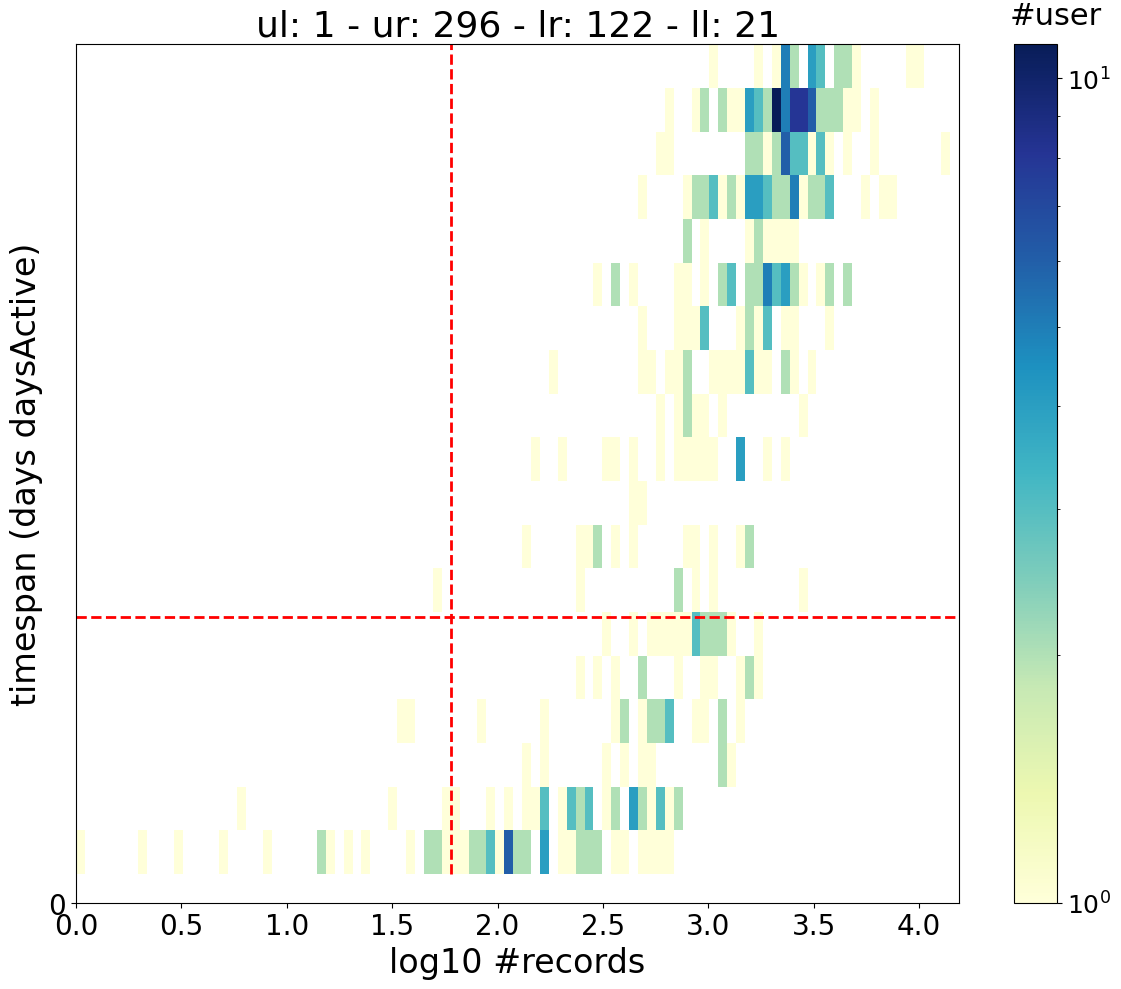

In [39]:
# load in the data for the bogota users for whom we detected at least one ping near a station of interest for further filtering 

output_folder = f'{data_dir}data/agg_data/'
min_pings, min_days = 60, 10
renamed_cols = ['uid', 'lat', 'lng', 'datetime', 'geohash', 'horizontal_accuracy', 'Nombre_de_l', 'Identificad']
user_dataquantity_filtered_filepath = f'{output_folder}{data_label}_users_w_ping_1km_stations_{min_pings}minpings_{min_days}mindays_in_bogota_region.csv'
calculate_filter_user_stats(user_filtered_data_filepath, cols_to_keep, renamed_cols, user_dataquantity_filtered_filepath, min_pings=min_pings, min_days=min_days) 

In [21]:
# filter the data for this final set of users to compute which ones have home locations near the stations: 
users = get_user_list(user_dataquantity_filtered_filepath, user_col='uid')
user_dataquantity_filtered_data_filepath = f'{output_folder}{data_label}_data_for_users_w_ping_1km_stations_{min_pings}minpings_{min_days}mindays_in_bogota_region.csv'
write_filter_data_by_users(data_folder, users, user_dataquantity_filtered_data_filepath)

Wrote data for the 296 of a total of 9459 users for this dataset.


In [22]:
ddf = read_preprocess_dash(user_dataquantity_filtered_data_filepath, cols_to_keep, renamed_cols)
ddf.head()

,uid,lat,lng,datetime,geohash,horizontal_accuracy,Nombre_de_l,Identificad
0,211c34a0-2b94-430a-b3f5-91be21899b39,4.756607,-74.063950,2019-02-08 17:19:32-05:00,d2g749um0zu6,3.0,SUBA,11
1,bdec31fc-2d31-47de-9900-040cf4a516bd,4.697989,-74.069344,2019-02-08 16:57:04-05:00,d2g6dx0rg0w7,3.0,SUBA,11
2,ef8039ab-c430-4adf-ad19-9e75091bf715,4.718589,-74.075500,2019-02-08 11:28:39-05:00,d2g6f6gzg8xq,4.0,SUBA,11
3,ef8039ab-c430-4adf-ad19-9e75091bf715,4.758795,-74.056000,2019-02-08 11:06:10-05:00,d2g74f61fpsk,3.0,SUBA,11
4,be8973bc-7085-4268-8c03-2760994a2a25,4.709535,-74.075775,2019-02-08 14:04:13-05:00,d2g6f37ej2fx,4.0,SUBA,11


In [23]:
shapefile = f'{meta_folder}Stations_Buffer_1000.shp'
ddf_w_zones, tessellation_gdf, df_hw_locs = find_home_work_locs(ddf, shapefile, home_hrs=(22.0, 6.0), work_hrs=(9.5,16.5))

In [24]:
tessellation_gdf_w_home =pd.merge(tessellation_gdf,df_hw_locs.groupby(by="home_tile_ID").count().reset_index()[["home_tile_ID","home_pings"]],left_on="tile_ID",right_on="home_tile_ID")

### Lets count and visualize the number of users that live near the stations

Make nicer plots later on

In [25]:
print('The breakdown of users living by different stations that we can detect is as follows:\n', tessellation_gdf_w_home[['Station', 'home_pings']])
print(f"There are {tessellation_gdf_w_home['home_pings'].sum()} users that live near the stations that pass the filtering conditions for min pings and days detected.")
tessellation_gdf_w_home

The breakdown of users living by different stations that we can detect is as follows:
               Station  home_pings
0            El Tunal         145
1       Juan Pablo II           6
2             Manitas           4
3  Mirador El Paraiso           2
There are 157 users that live near the stations that pass the filtering conditions for min pings and days detected.


,Station,Y_wgs,X_wgs,BUFF_DIST,ORIG_FID,Shape_Leng,Shape_Area,geometry,tile_ID,home_tile_ID,home_pings
0,El Tunal,4.569088,-74.139714,1000.0,1,0.056719,0.000256,"POLYGON ((-74.13971 4.57813, -74.13946 4.57813...",0,0.0,145
1,Juan Pablo II,4.556036,-74.147474,1000.0,2,0.056718,0.000256,"POLYGON ((-74.14747 4.56508, -74.14722 4.56508...",1,1.0,6
2,Manitas,4.550582,-74.150299,1000.0,3,0.056718,0.000256,"POLYGON ((-74.15030 4.55962, -74.15004 4.55962...",2,2.0,4
3,Mirador El Paraiso,4.550355,-74.158587,1000.0,4,0.056718,0.000256,"POLYGON ((-74.15859 4.55940, -74.15833 4.55939...",3,3.0,2


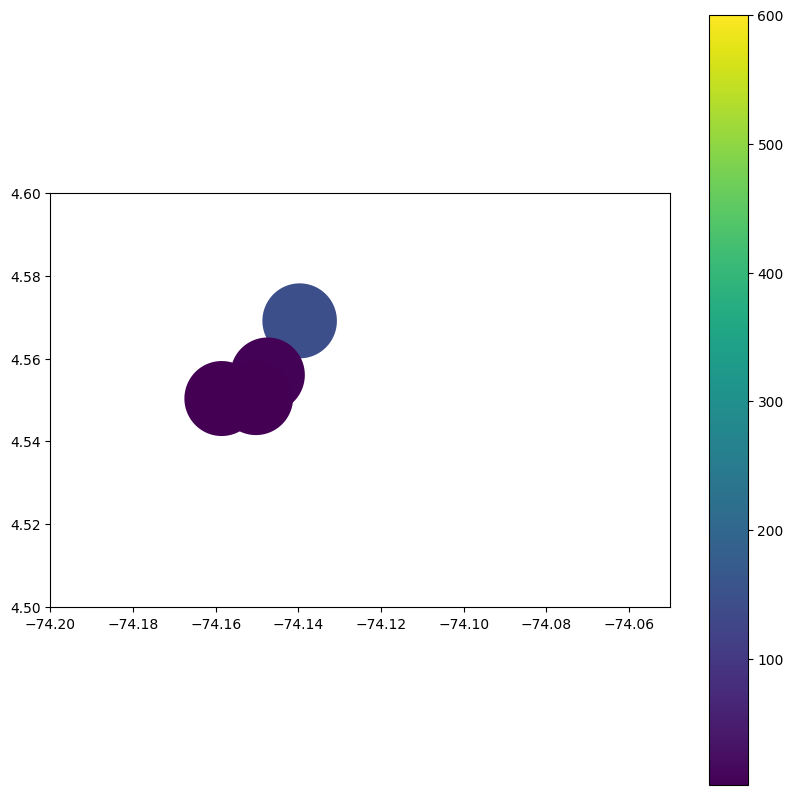

In [26]:
plot_folder = f'{data_dir}figures/'

fig,ax=plt.subplots(figsize=(10,10))
ax.set_ylim([4.3,5])
ax.set_ylim([4.5,4.6])
ax.set_xlim([-74.2,-74.05])
tessellation_gdf_w_home.plot(column="home_pings",ax=ax,legend=True,vmax=600)
plt.savefig(f'{plot_folder}{data_label}_station_zones_map_home_10pm_6am.png', dpi=200)
plt.show()

In [34]:
output_file_path_no_ext = f'{data_dir}/data/agg_data/{data_label}_users_w_ping_1km_stations_{min_pings}pings_{min_days}days'
filter_for_users_living_in_specified_regions(df_hw_locs, output_file_path_no_ext)

Out of 296 users, 157 have a home tile ID assigned, and 69 have a home ping in the regions specified.


### Getting the final data for these users to work with

In [35]:
print(data_folder) # data folder should pull from the localidades
output_file_path_no_ext = f'{data_dir}data/agg_data/{data_label}_users_w_ping_1km_stations_{min_pings}pings_{min_days}days'
min_pings, min_days = 60, 10

# filter the data for this final set of users to compute which ones have home locations near the stations: 
final_user_hometile_filepath = output_file_path_no_ext + '_w_hometile.csv'
users = get_user_list(final_user_hometile_filepath, user_col='uid')
final_filtered_hometile_filepath = f'{data_dir}data/agg_data/{data_label}_data_for_users_w_ping_1km_stations_{min_pings}pings_{min_days}days_w_hometile.csv'
write_filter_data_by_users(data_folder, users, final_filtered_hometile_filepath)

final_user_homeping_filepath = output_file_path_no_ext + '_w_homeping.csv'
users = get_user_list(final_user_homeping_filepath, user_col='uid')
final_filtered_homeping_filepath = f'{data_dir}data/agg_data/{data_label}_data_for_users_w_ping_1km_stations_{min_pings}pings_{min_days}days_w_homeping.csv'
write_filter_data_by_users(data_folder, users, final_filtered_homeping_filepath)

/Users/emilyrobitschek/git/ETH/SPUR/mobile_data_colombia/data/bogota_localidades/year=2019_month=2/
Wrote data for the 157 of a total of 9459 users for this dataset.
Wrote data for the 69 of a total of 9459 users for this dataset.


### Working with multiple folders of input data

In [4]:
# load in the data for the bogota users for whom we detected at least one ping near a station of interest for further filtering 
data_label ='year=2019_month=1-2'
label_jan_2019 = 'year=2019_month=1'
label_feb_2019 = 'year=2019_month=2'
labels = [label_jan_2019, label_feb_2019]
users_w_ping_near_station_filepaths = [f'{data_dir}data/agg_data/{label}_users_w_ping_1km_stations.csv' for label in labels]

cols_to_keep = ['user_id', 'lat', 'lng', 'datetime', 'geohash', 'horizontal_accuracy', 'Nombre_de_l', 'Identificad']
data_folder = f'{data_dir}data/bogota_localidades/{data_label}/'

# read in the data from the bogota area and restrict it to those users with at least one ping in the area of one of the stations
def get_unique_user_list_from_multiple_months(user_files: list, user_col="user_id"):
    """Takes in a file (user_file) with a single column of user ids and exports a list of those users"""
    users = dd.read_csv(user_files)
    return list(set(users[user_col]))

users = get_unique_user_list_from_multiple_months(users_w_ping_near_station_filepaths)
print(len(users))

13800


In [5]:
# filter the data for this final set of users to compute which ones have home locations near the stations: 
data_folders = [f'{data_dir}data/bogota_localidades/{label}/' for label in labels]
output_folder = f'{data_dir}data/agg_data/'

filepaths = get_csv_paths_multifolder(data_folders)
user_filtered_data_filepath = f'{output_folder}{data_label}_data_for_users_w_ping_1km_stations.csv'

write_filter_data_by_users_from_filepaths(filepaths, users, user_filtered_data_filepath)

59 files read from 2 folders, ['/Users/emilyrobitschek/git/ETH/SPUR/mobile_data_colombia/data/bogota_localidades/year=2019_month=1/', '/Users/emilyrobitschek/git/ETH/SPUR/mobile_data_colombia/data/bogota_localidades/year=2019_month=2/']
Wrote data for the 13800 of a total of 502149 users for this dataset.


Based on 60 ping and 10 day mininum cutoffs, kept 2310 of a total of 13800 users for this dataset.


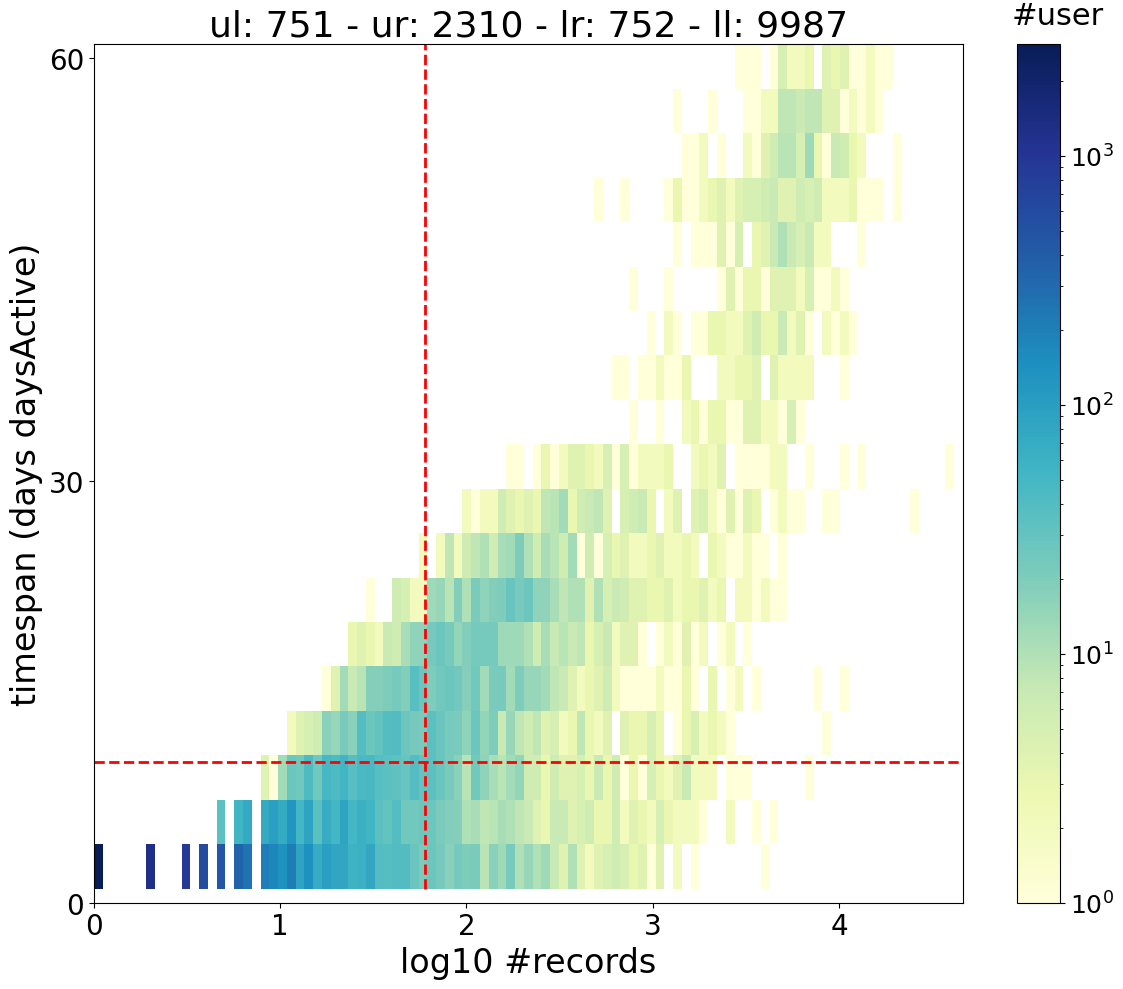

In [6]:
# load in the data for the bogota users for whom we detected at least one ping near a station of interest for further filtering 
min_pings, min_days = 60, 10
renamed_cols = ['uid', 'lat', 'lng', 'datetime', 'geohash', 'horizontal_accuracy', 'Nombre_de_l', 'Identificad']
user_dataquantity_filtered_filepath = f'{output_folder}{data_label}_users_w_ping_1km_stations_{min_pings}minpings_{min_days}mindays_in_bogota_region.csv'
calculate_filter_user_stats(user_filtered_data_filepath, cols_to_keep, renamed_cols, user_dataquantity_filtered_filepath, min_pings=min_pings, min_days=min_days) 

In [7]:
# filter the data for this final set of users to compute which ones have home locations near the stations: 
users = get_user_list(user_dataquantity_filtered_filepath, user_col='uid')
user_dataquantity_filtered_data_filepath = f'{output_folder}{data_label}_data_for_users_w_ping_1km_stations_{min_pings}minpings_{min_days}mindays_in_bogota_region.csv'
write_filter_data_by_users_from_filepaths(filepaths, users, user_dataquantity_filtered_data_filepath)

Wrote data for the 2310 of a total of 502149 users for this dataset.


### Now we are done with writing the data for now and we can try visualizing it!

#### Let's visualize the data as above!

In [8]:
ddf = read_preprocess_dash(user_dataquantity_filtered_data_filepath, cols_to_keep, renamed_cols)
ddf.head()

,uid,lat,lng,datetime,geohash,horizontal_accuracy,Nombre_de_l,Identificad
0,3f9b26d7-4722-4ef4-8f22-9db65e47410e,4.736778,-74.058460,2019-01-29 20:14:29-05:00,d2g6fy238zkq,65.000000,SUBA,11
1,e816138e-facd-4f80-8959-c85d26f51311,4.698456,-74.059720,2019-01-29 20:12:12-05:00,d2g6dxr67rsh,5.000000,SUBA,11
2,900e7d67-ad3d-4d6f-a2d5-ba6c5ff2a0f0,4.741282,-74.056206,2019-01-30 06:14:42-05:00,d2g6fz1gvr48,5.000000,SUBA,11
3,412ab9fa-5a53-4538-9735-8e4d2c80ed84,4.742762,-74.086190,2019-01-29 20:42:03-05:00,d2g6fpkhddv7,6.000906,SUBA,11
4,75068f18-8ff5-4a2d-a452-2952c053934a,4.742363,-74.065470,2019-01-30 08:01:33-05:00,d2g6fx74m883,6.000906,SUBA,11


In [9]:
shapefile = f'{meta_folder}Stations_Buffer_1000.shp'
ddf_w_zones, tessellation_gdf, df_hw_locs = find_home_work_locs(ddf, shapefile, home_hrs=(22.0, 6.0), work_hrs=(9.5,16.5))
tessellation_gdf_w_home =pd.merge(tessellation_gdf,df_hw_locs.groupby(by="home_tile_ID").count().reset_index()[["home_tile_ID","home_pings"]],left_on="tile_ID",right_on="home_tile_ID")

print('The breakdown of users living by different stations that we can detect is as follows:\n', tessellation_gdf_w_home[['Station', 'home_pings']])
print(f"There are {tessellation_gdf_w_home['home_pings'].sum()} users that live near the stations that pass the filtering conditions for min pings and days detected.")
tessellation_gdf_w_home

The breakdown of users living by different stations that we can detect is as follows:
               Station  home_pings
0            El Tunal         948
1       Juan Pablo II         237
2             Manitas         221
3  Mirador El Paraiso         123
There are 1529 users that live near the stations that pass the filtering conditions for min pings and days detected.


,Station,Y_wgs,X_wgs,BUFF_DIST,ORIG_FID,Shape_Leng,Shape_Area,geometry,tile_ID,home_tile_ID,home_pings
0,El Tunal,4.569088,-74.139714,1000.0,1,0.056719,0.000256,"POLYGON ((-74.13971 4.57813, -74.13946 4.57813...",0,0.0,948
1,Juan Pablo II,4.556036,-74.147474,1000.0,2,0.056718,0.000256,"POLYGON ((-74.14747 4.56508, -74.14722 4.56508...",1,1.0,237
2,Manitas,4.550582,-74.150299,1000.0,3,0.056718,0.000256,"POLYGON ((-74.15030 4.55962, -74.15004 4.55962...",2,2.0,221
3,Mirador El Paraiso,4.550355,-74.158587,1000.0,4,0.056718,0.000256,"POLYGON ((-74.15859 4.55940, -74.15833 4.55939...",3,3.0,123


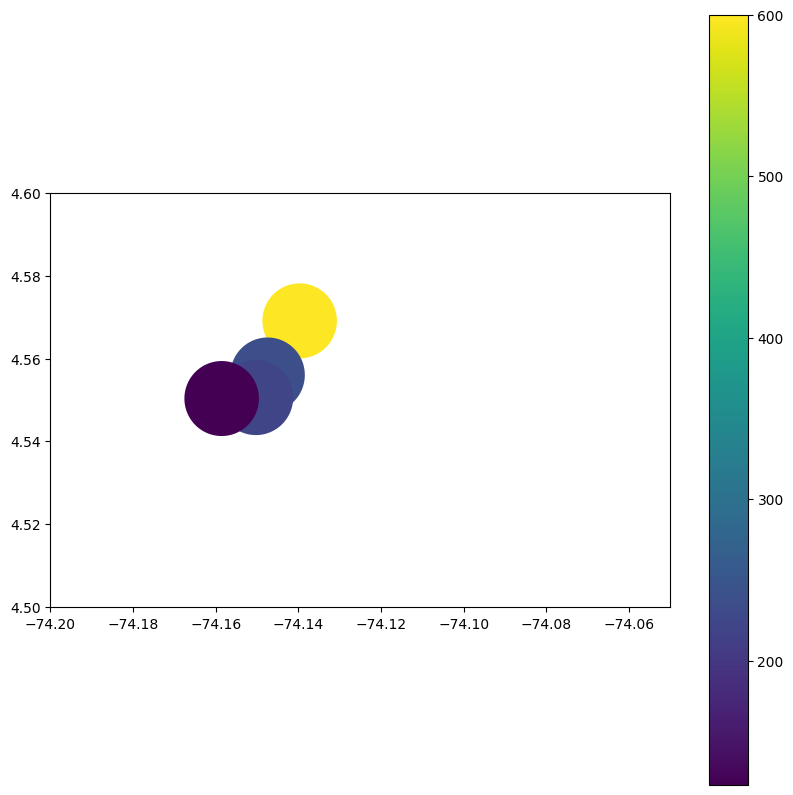

In [10]:
plot_folder = f'{data_dir}figures/'

fig,ax=plt.subplots(figsize=(10,10))
ax.set_ylim([4.3,5])
ax.set_ylim([4.5,4.6])
ax.set_xlim([-74.2,-74.05])
tessellation_gdf_w_home.plot(column="home_pings",ax=ax,legend=True,vmax=600)
plt.savefig(f'{plot_folder}{data_label}_station_zones_map_home_10pm_6am.png', dpi=200)
plt.show()

### Write out the final data to work with for the multiple months

In [11]:
output_file_path_no_ext = f'{data_dir}/data/agg_data/{data_label}_users_w_ping_1km_stations_{min_pings}pings_{min_days}days'
filter_for_users_living_in_specified_regions(df_hw_locs, output_file_path_no_ext)
print(data_folder) # data folder should pull from the localidades
min_pings, min_days = 60, 10

# filter the data for this final set of users to compute which ones have home locations near the stations: 
final_user_hometile_filepath = output_file_path_no_ext + '_w_hometile.csv'
users = get_user_list(final_user_hometile_filepath, user_col='uid')
final_filtered_hometile_filepath = f'{data_dir}data/agg_data/{data_label}_data_for_users_w_ping_1km_stations_{min_pings}pings_{min_days}days_w_hometile.csv'
write_filter_data_by_users_from_filepaths(filepaths, users, final_filtered_hometile_filepath)

final_user_homeping_filepath = output_file_path_no_ext + '_w_homeping.csv'
users = get_user_list(final_user_homeping_filepath, user_col='uid')
final_filtered_homeping_filepath = f'{data_dir}data/agg_data/{data_label}_data_for_users_w_ping_1km_stations_{min_pings}pings_{min_days}days_w_homeping.csv'
write_filter_data_by_users_from_filepaths(filepaths, users, final_filtered_homeping_filepath)

Out of 2310 users, 1529 have a home tile ID assigned, and 968 have a home ping in the regions specified.
/Users/emilyrobitschek/git/ETH/SPUR/mobile_data_colombia/data/bogota_localidades/year=2019_month=1-2/
Wrote data for the 1529 of a total of 502149 users for this dataset.
Wrote data for the 968 of a total of 502149 users for this dataset.


### Compute some visualizations

In [12]:
final_ddf = dd.read_csv(final_filtered_homeping_filepath)
final_df = final_ddf.compute()
print(len(final_df), final_df.columns)
final_df.columns
final_df.head()

936551 Index(['index', 'user_id', 'lat', 'lng', 'datetime', 'geohash',
       'horizontal_accuracy', 'Nombre_de_l', 'Identificad'],
      dtype='object')


,index,user_id,lat,lng,datetime,geohash,horizontal_accuracy,Nombre_de_l,Identificad
0,70,68a16895-0fe7-4726-8415-485aaeae0b8f,4.760723,-74.047570,1548820649000,d2g7548jnx47,16.64561,SUBA,11
1,120,68a16895-0fe7-4726-8415-485aaeae0b8f,4.760812,-74.047610,1548829035000,d2g7548jtxwh,10.00000,SUBA,11
2,179,38b0ff07-1dd2-4ba4-9d9c-01644dbc9c05,4.694549,-74.056020,1548888927000,d2g6dyd59x7h,3.00000,SUBA,11
3,340,60f5873b-1a66-43dc-9e98-642de809b321,4.704979,-74.069180,1548811428998,d2g6f882qztu,53.29000,SUBA,11
4,341,60f5873b-1a66-43dc-9e98-642de809b321,4.705134,-74.068634,1548811428998,d2g6f88c7sx3,27.27000,SUBA,11


AttributeError: 'FigureCanvasAgg' object has no attribute 'renderer'

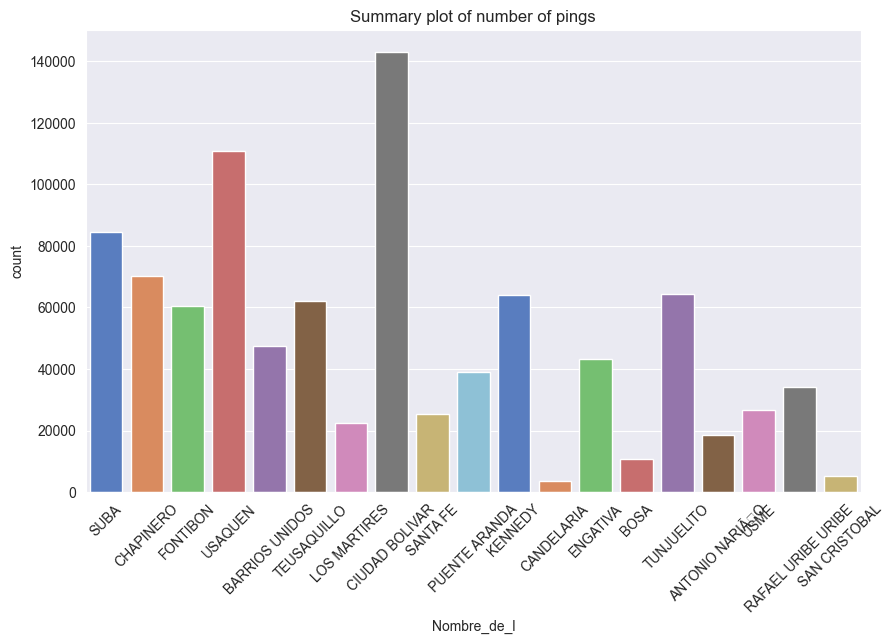

In [13]:
df = final_df
import seaborn as sns
import plotly.express as px

#print(df.columns)
# Create a bar plot with different colors for each value of "Nombre_de_I"
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
sns.countplot(x='Nombre_de_l', data=df, palette='muted')
plt.title('Summary plot of number of pings')
plt.xticks(rotation=45)

# Convert the seaborn plot to an interactive plot using plotly
fig = px.imshow(plt.gcf().canvas.buffer_rgba(), binary_string=True)
fig.show()

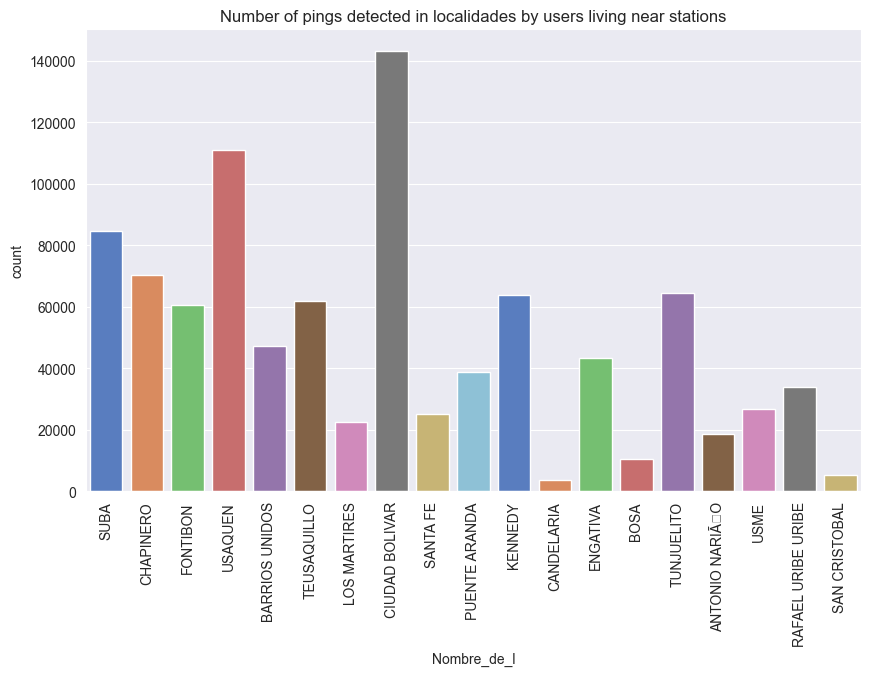

In [ ]:
from PIL import Image

# Create a bar plot with different colors for each value of "Nombre_de_I"
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
sns.countplot(x='Nombre_de_l', data=df, palette='muted')
plt.xticks(rotation=90)
plt.title('Number of pings detected in localidades by users living near stations')

# Save the plot to a file and read it back in using PIL
plt.savefig('/figures/pings_localidades_users_whome_near_stations_plot_jan_feb_2019.png', dpi=200, bbox_inches='tight', pad_inches=0)
image = Image.open('/figures/pings_localidades_users_whome_near_stations_plot_jan_feb_2019.png')

# Convert the PIL image to a plotly figure
fig = px.imshow(image)
fig.show()

#### Let's plot a small fraction of this data

In [14]:
shapefile_path = f'{meta_folder}poligonos-localidades.shp'

def plot_frac_data_on_map(shapefile_path, ddf, frac=0.001):
    user_data = ddf.sample(frac=frac).compute()
    map_df=gpd.read_file(shapefile_path)

    # Create a folium map centered on the user's latitude and longitude
    center_lat = user_data.iloc[0]['lat']
    center_lng = user_data.iloc[0]['lng']
    map_obj = folium.Map(location=[center_lat, center_lng], zoom_start=10)

    # Add markers for each measurement
    for index, row in user_data.iterrows():
        folium.Marker([row['lat'], row['lng']]).add_to(map_obj)

    # Add the shapefile as an overlay
    folium.GeoJson(map_df).add_to(map_obj)
    return map_obj, user_data

map_obj, user_data = plot_frac_data_on_map(shapefile_path, final_ddf, frac=0.0001)
map_obj

In [31]:
user_data_for_map = dd.read_csv(user_dataquantity_filtered_filepath).sort_values(by=["pings"],ascending=False).compute()
user_data_for_map[650:660]

,uid,min_day,max_day,pings,daysActive,daysSpanned,pingsPerDay,avg
1251,48cc727f-0eca-43c6-a2f4-2855cacde8ec,2018-12-31 00:00:00-05:00,2019-01-31 00:00:00-05:00,1098,26,31,"[19, 316, 9, 6, 106, 27, 2, 3, 2, 14, 23, 8, 1...",42.230769
1002,a30d3049-bed5-4f65-8758-28e02d3f8aee,2019-01-09 00:00:00-05:00,2019-02-25 00:00:00-05:00,1075,34,47,"[21, 17, 16, 4, 11, 2, 45, 3, 2, 2, 32, 2, 84,...",31.617647
983,94d97c0e-d33e-4639-b784-5cb3709eb080,2019-01-04 00:00:00-05:00,2019-02-28 00:00:00-05:00,1069,24,55,"[98, 12, 159, 9, 108, 5, 6, 3, 183, 49, 2, 80,...",44.541667
506,5bd8e4fe-f975-4084-a2e4-7eb3f04d9fd2,2019-01-02 00:00:00-05:00,2019-02-22 00:00:00-05:00,1064,36,51,"[40, 1, 2, 2, 7, 41, 2, 2, 110, 2, 1, 3, 4, 21...",29.555556
354,ed5199cc-5c02-440a-bbd1-47572bc4a704,2018-12-31 00:00:00-05:00,2019-01-31 00:00:00-05:00,1059,31,31,"[1, 3, 3, 11, 38, 11, 5, 3, 1, 8, 231, 236, 13...",34.161290
1997,372d3af6-3504-4bef-9623-32f917909539,2019-01-29 00:00:00-05:00,2019-02-21 00:00:00-05:00,1055,22,23,"[29, 29, 29, 54, 44, 62, 24, 77, 63, 56, 98, 1...",47.954545
1911,f9cac6a0-136e-4642-9d9d-ea5b8e5ac931,2019-01-05 00:00:00-05:00,2019-01-17 00:00:00-05:00,1054,12,12,"[1, 16, 9, 12, 131, 11, 139, 403, 251, 73, 6, 2]",87.833333
1261,4ef39e1f-8634-4118-8e21-4f7eb8b9744e,2019-01-01 00:00:00-05:00,2019-01-10 00:00:00-05:00,1043,10,9,"[5, 178, 145, 163, 225, 6, 73, 81, 164, 3]",104.300000
1552,12cba3b2-f81a-4f1e-9c56-0aaed8c1a21f,2019-01-02 00:00:00-05:00,2019-02-02 00:00:00-05:00,1038,14,31,"[47, 201, 8, 218, 4, 63, 3, 19, 106, 197, 18, ...",74.142857
1144,f4f0528d-c07c-44b1-8a3e-7a75f1942df0,2018-12-31 00:00:00-05:00,2019-01-29 00:00:00-05:00,1022,27,29,"[2, 11, 30, 36, 18, 11, 8, 9, 17, 303, 6, 2, 2...",37.851852


In [32]:
def plot_user_on_map(shapefile_path, df, user_id):
    user_data = df[df['user_id']==user_id].copy().reset_index() #[cols]
    map_df=gpd.read_file(shapefile_path)

    # Create a folium map centered on the user's latitude and longitude
    center_lat = user_data.iloc[0]['lat']
    center_lng = user_data.iloc[0]['lng']
    map_obj = folium.Map(location=[center_lat, center_lng], zoom_start=10)

    # Add markers for each measurement
    for index, row in user_data.iterrows():
        folium.Marker([row['lat'], row['lng']]).add_to(map_obj)

    # Add the shapefile as an overlay
    folium.GeoJson(map_df).add_to(map_obj)
    return map_obj, user_data

In [33]:
user_to_viz = '010b00b9-61f9-41c6-a39a-db6b79cd9836'
map_obj, user_data = plot_user_on_map(shapefile_path, final_df, user_to_viz)
map_obj

In [ ]:
user_to_viz1 = '12cba3b2-f81a-4f1e-9c56-0aaed8c1a21f'
map_obj1, user_data1 = plot_user_on_map(shapefile_path, final_df, user_to_viz)

#user_to_viz = '49c39024-cfb6-490c-a1e8-131fd5c57a52'
#map_obj_bottom, user_data_bottom = plot_user_on_map(shapefile_path, final_df, user_to_viz)